# Assignment 4: Street Networks & Web Scraping

**Part 1: Visualizing crash data in Philadelphia**

In this section, you will use `osmnx` to analyze the crash incidence in Center City. 


**Part 2: Scraping Craigslist**

In this section, you will use Selenium and BeautifulSoup to scrape data for hundreds of apartments from Philadelphia's Craigslist portal.


## Part 1: Visualizing crash data in Philadelphia

### 1.1 Load the geometry for the region being analyzed

We'll analyze crashes in the "Central" planning district in Philadelphia, a rough approximation for Center City. [Planning districts](https://www.opendataphilly.org/dataset/planning-districts) can be loaded from Open Data Philly. Read the data into a GeoDataFrame using the following link:

[http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson](http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson)

Select the "Central" district and extract the geometry polygon for only this district. After this part, you should have a polygon variable of type `shapely.geometry.polygon.Polygon`.

In [1]:
import geopandas as gpd

url='http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson'

phil_boundary = gpd.read_file(url)
central_boundary = phil_boundary[phil_boundary["DIST_NAME"] == 'Central']
central_boundary = central_boundary.squeeze()
geom = central_boundary.geometry

### 1.2 Get the street network graph

Use OSMnx to create a network graph (of type 'drive') from your polygon boundary in 1.1.

In [2]:
import osmnx as ox

G = ox.graph_from_polygon(geom, network_type="drive")

### 1.3 Convert your network graph edges to a GeoDataFrame

Use OSMnx to create a GeoDataFrame of the network edges in the graph object from part 1.2. The GeoDataFrame should contain the edges but not the nodes from the network.

In [3]:
roads = ox.utils_graph.graph_to_gdfs(G, edges=True, nodes=False)

### 1.4 Load PennDOT crash data

Data for crashes (of all types) for 2020, 2021, and 2022 in Philadelphia County is available at the following path:

`./data/CRASH_PHILADELPHIA_XXXX.csv`

You should see three separate files in the `data/` folder. Use pandas to read each of the CSV files, and combine them into a single dataframe using `pd.concat()`.

The data was downloaded for Philadelphia County [from here](https://crashinfo.penndot.gov/PCIT/welcome.html).

In [4]:
import os

In [5]:
import pandas as pd

files = [f for f in os.listdir('./data') if f.endswith('.csv')]

dfs = []
for f in files:
    path = './data/' + f
    df = pd.read_csv(path)
    dfs.append(df)

crash_data = pd.concat(dfs)

### 1.5 Convert the crash data to a GeoDataFrame

You will need to use the `DEC_LAT` and `DEC_LONG` columns for latitude and longitude.

The full data dictionary for the data is [available here](http://pennshare.maps.arcgis.com/sharing/rest/content/items/ffe20c6c3c594389b275c6772a281bcd/data)

In [6]:
long = crash_data['DEC_LONG']
lat = crash_data['DEC_LAT']

crash_gdf = gpd.GeoDataFrame(
    crash_data, geometry=gpd.points_from_xy(long, lat), crs="EPSG:4326"
)

### 1.6 Trim the crash data to Center City

1. Get the boundary of the edges data frame (from part 1.3). Accessing the `.geometry.unary_union.convex_hull` property will give you a nice outer boundary region.
1. Trim the crashes using the `within()` function of the crash GeoDataFrame to find which crashes are within the boundary.

There should be about 3,750 crashes within the Central district.

In [7]:
roads_boundary = roads.geometry.unary_union.convex_hull

in_ccity = crash_gdf.within(roads_boundary)

crash_in_ccity = crash_gdf.loc[in_ccity]

C:\ProgramData\mambaforge\envs\musa-550-fall-2023\lib\site-packages\shapely\predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)


### 1.7 Re-project our data into an approriate CRS

We'll need to find the nearest edge (street) in our graph for each crash. To do this, `osmnx` will calculate the distance from each crash to the graph edges. For this calculation to be accurate, we need to convert from latitude/longitude 

**We'll convert the local state plane CRS for Philadelphia, EPSG=2272**

#### Two steps:
1. Project the graph object (`G`) using the `ox.project_graph`. Run `ox.project_graph?` to see the documentation for how to convert to a specific CRS. 
1. Project the crash data using the `.to_crs()` function.

In [8]:
G_project = ox.project_graph(G,to_crs='2272')
crash_in_ccity = crash_in_ccity.to_crs('2272')

### 1.8 Find the nearest edge for each crash

See: `ox.distance.nearest_edges()`. It takes three arguments:

- the network graph
- the longitude of your crash data (the `x` attribute of the `geometry` column)
- the latitude of your crash data (the `y` attribute of the `geometry` column)

You will get a numpy array with 3 columns that represent `(u, v, key)` where each `u` and `v` are the node IDs that the edge links together. We will ignore the `key` value for our analysis.

In [9]:
x = crash_in_ccity.geometry.x
y = crash_in_ccity.geometry.y

distance = ox.distance.nearest_edges(G_project,x,y)

### 1.9 Calculate the total number of crashes per street

1. Make a DataFrame from your data from part 1.7 with three columns, `u`, `v`, and `key` (we will only use the `u` and `v` columns)
1. Group by `u` and `v` and calculate the size
1. Reset the index and name your `size()` column as `crash_count`

After this step you should have a DataFrame with three columns: `u`, `v`, and `crash_count`.

In [10]:
df = pd.DataFrame(distance, columns = ['u','v','key'])
df_count = df.groupby(['u','v'],as_index=False).count()
df_count.rename({"key":"crash_count"},axis=1,inplace=True)

### 1.10 Merge your edges GeoDataFrame and crash count DataFrame

You can use pandas to merge them on the `u` and `v` columns. This will associate the total crash count with each edge in the street network. 

**Tips:** 
   - Use a `left` merge where the first argument of the merge is the edges GeoDataFrame. This ensures no edges are removed during the merge.
   - Use the `fillna(0)` function to fill in missing crash count values with zero.

In [11]:
roads = roads.reset_index()[['u','v','geometry','length']]
roads = roads.merge(df_count,how='left',on=['u','v'])
roads = roads.fillna(0)

### 1.11 Calculate a "Crash Index"

Let's calculate a "crash index" that provides a normalized measure of the crash frequency per street. To do this, we'll need to:

1. Calculate the total crash count divided by the street length, using the `length` column
1. Perform a log transformation of the crash/length variable — use numpy's `log10()` function
1. Normalize the index from 0 to 1 (see the lecture notes for an example of this transformation)

**Note: since the crash index involves a log transformation, you should only calculate the index for streets where the crash count is greater than zero**.

After this step, you should have a new column in the data frame from 1.9 that includes a column called part 1.9.

In [12]:
import numpy as np
                
roads_filt = roads[roads['crash_count'] > 0]

roads_filt['crash_index'] = np.log10(roads_filt['crash_count'] / roads_filt['length'])

min_max_diff = roads_filt['crash_index'].max() - roads_filt['crash_index'].min()
min1 = roads_filt['crash_index'].min()

roads_filt['crash_index_normalize'] = (roads_filt['crash_index'] - min1) / min_max_diff

roads_filt = pd.DataFrame(roads_filt.drop(columns='geometry'))

C:\ProgramData\mambaforge\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\ProgramData\mambaforge\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### 1.12 Plot a histogram of the crash index values

Use matplotlib's `hist()` function to plot the crash index values from the previous step.

You should see that the index values are Gaussian-distributed, providing justification for why we log-transformed!

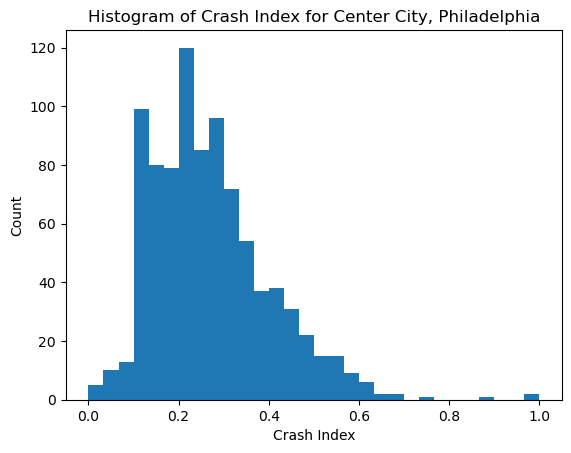

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.hist(roads_filt['crash_index_normalize'],bins=30)

plt.ylabel('Count')
plt.xlabel('Crash Index')
plt.title('Histogram of Crash Index for Center City, Philadelphia')

plt.show()


### 1.13 Plot an interactive map of the street networks, colored by the crash index

You can use GeoPandas to make an interactive Folium map, coloring the streets by the crash index column.

**Tip:** if you use the viridis color map, try using a "dark" tile set for better constrast of the colors.

In [14]:
'''
Note this merge was not part of assignment, but I decided to show roads which have a count of 0 as 0s for the index
in the map as it looked odd to have road segments without data in the map
'''

roads_merge = roads[['u','v','geometry']].merge(roads_filt,how='left',on=['u','v'])
roads_merge = roads_merge.fillna(0)

roads_merge.explore(
    column="crash_index_normalize",
    cmap="plasma",
    tiles="CartoDB dark_matter",
)

## Part 2: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using Selenium and BeautifulSoup to extract the relevant information from the HTML text. 

For reference on CSS selectors, please see the [notes from Week 6](https://github.com/MUSA-550-Fall-2022/week-6/blob/main/css-selectors.md).

### Primer: the Craigslist website URL

We'll start with the Philadelphia region. First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. 

[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0)

There are **three** components to this URL. 

1. The base URL: `http://philadelphia.craigslist.org/search/apa`

2. The user's search parameters: `?min_price=1&min_bedrooms=1&minSqft=1`

> We will send nonzero defaults for some parameters (bedrooms, size, price) in order to exclude results that have empty values for these parameters.


3. The URL *hash*: `#search=1~gallery~0~0`

> As we will see later, this part will be important because it contains the search page result number.


The Craigslist website requires Javascript, so we'll need to use Selenium to load the page, and then use BeautifulSoup to extract the information we want. 



### 2.1 Initialize a selenium driver and open Craigslist

As discussed in lecture, you can use Chrome, Firefox, or Edge as your selenium driver. In this part, you should do two things:

1. Initialize the selenium driver
1. Use the `driver.get()` function to open the following URL:

[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0)

This will give you the search results for 1-bedroom apartments in Philadelphia.


In [34]:
from bs4 import BeautifulSoup
from selenium import webdriver

In [35]:
driver = webdriver.Chrome()

url = 'https://philadelphia.craigslist.org/search/apa?minSqft=1&min_bedrooms=1&min_price=1#search=1~gallery~0~0'
driver.get(url)

### 2.2 Initialize your "soup"

Once selenium has the page open, we can get the page source from the driver and use BeautifulSoup to parse it. In this part, initialize a BeautifulSoup object with the driver's page source



In [36]:
craigslist_soup = BeautifulSoup(driver.page_source, "html.parser")

### 2.3 Parsing the HTML

Now that we have our "soup" object, we can use BeautifulSoup to extract out the elements we need:

- Use the Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML. 


At the end of this part, you should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [37]:
selector = '.gallery-card'

lists = craigslist_soup.select(selector)

### 2.4 Find the relevant pieces of information

We will now focus on the **first element** in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms
- The square footage
- The apartment title

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.


In [38]:
print(lists[0].prettify())

<div class="gallery-card">
 <div class="cl-gallery">
  <div class="gallery-inner">
   <a class="main" href="https://philadelphia.craigslist.org/apa/d/royersford-snow-place-like-home/7687692096.html">
    <div class="swipe" style="visibility: visible;">
     <div class="swipe-wrap" style="width: 18432px;">
      <div data-index="0" style="width: 384px; left: 0px; transition-duration: 0ms; transform: translateX(0px);">
       <span class="loading icom-">
       </span>
       <img alt="Snow Place Like Home! 1" src="https://images.craigslist.org/00M0M_cgLyH6RyWMB_0t20CI_300x300.jpg"/>
      </div>
      <div data-index="1" style="width: 384px; left: -384px; transition-duration: 0ms; transform: translateX(384px);">
      </div>
      <div data-index="2" style="width: 384px; left: -768px; transition-duration: 0ms; transform: translateX(384px);">
      </div>
      <div data-index="3" style="width: 384px; left: -1152px; transition-duration: 0ms; transform: translateX(384px);">
      </div>
 

In [39]:
price_selector = '.priceinfo'
bedroom_selector = '.post-bedrooms'
size_selector = '.post-sqft'
title_selector = '.cl-app-anchor'

el1 = lists[0]

price = el1.select_one(price_selector).text
print("The price is " + price)

rooms = el1.select_one(bedroom_selector).text
print('The number of bedrooms is ' + rooms)

size = el1.select_one(size_selector).text
print('The size is ' + size)

title = el1.select_one(title_selector).text
print(title)

The price is $1,999
The number of bedrooms is 2br
The size is 975ft2
Snow Place Like Home!


### 2.5 Functions to format the results 

In this section, you'll create functions that take in the raw string elements for price, size, and number of bedrooms and returns them formatted as numbers.

I've started the functions to format the values. You should finish theses functions in this section.

**Hints**
- You can use string formatting functions like `string.replace()` and `string.strip()`
- The `int()` and `float()` functions can convert strings to numbers

In [40]:
def format_bedrooms(bedrooms_string):
    bednum = int(bedrooms_string[0])
    return bednum


In [41]:
def format_size(size_string):
    size_string = size_string.replace("ft2","")
    int_size = int(size_string)
    return int_size


In [42]:
def format_price(price_string):
    price_string = price_string.replace("$","")
    price_string = price_string.replace(",","")
    int_price = int(price_string)
    return int_price


### 2.6 Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 5 pages of search results and scrape data for 600 apartments. 

We can get a specific page by changing the `search=PAGE` part of the URL hash. For example, to get page 2 instead of page 1, we will navigate to:


[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=2~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=2~gallery~0~0)

In the code below, the outer for loop will loop over 5 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

Fill in the missing pieces of the inner loop using the code from the previous section. We will be able to extract out the relevant pieces of info for each apartment. 

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 600 apartment listings.

#### Notes

Be careful if you try to scrape more listings. Craigslist will temporarily ban your IP address (for a very short time) if you scrape too much at once. I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

If the for loop gets stuck at the "Processing page X..." step for more than a minute or so, your IP address is probably banned temporarily, and you'll have to wait a few minutes before trying again.

In [43]:
from time import sleep

In [44]:
import pandas as pd

results = []

# search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5

# The base URL we will be usin1
base_url= "https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1"

# loop over each page of search results
for page_num in range(0, max_pages):
    print(f"Processing page {page_num}...")

    # Update the URL hash for this page number and make the combined URL
    url_hash = f"#search=1~gallery~{page_num}~0"
    url = base_url + url_hash
    print(url)
    # Go to the driver and wait for 5 seconds
    driver.get(url)
    sleep(5)
    # YOUR CODE: get the list of all apartments
    # This is the same code from Part 1.2 and 1.3
    # It should be a list of 120 apartments
    soup = BeautifulSoup(driver.page_source, "html.parser")
    apts = soup.select(selector)
    print("Number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:

        # YOUR CODE: the bedrooms string
        bedrooms = apt.select_one(bedroom_selector).text

        # YOUR CODE: the size string
        size = apt.select_one(size_selector).text
        
        # YOUR CODE: the title string
        title = apt.select_one(title_selector).text

        # YOUR CODE: the price string
        price = apt.select_one(price_selector).text

        # Format using functions from Part 1.5
        bedrooms = format_bedrooms(bedrooms)
        size = format_size(size)
        price = format_price(price)

        # Save the result
        page_results.append([price, size, bedrooms, title])

    # Create a dataframe and save
    col_names = ["price", "size", "bedrooms", "title"]
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)

    print("sleeping for 10 seconds between calls")
    sleep(10)

# Finally, concatenate all the results
results = pd.concat(results, axis=0).reset_index(drop=True)

Processing page 0...
https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 1...
https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~1~0
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 2...
https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~2~0
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 3...
https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~3~0
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 4...
https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~4~0
Number of apartments =  120
sleeping for 10 seconds between calls


### 2.7 Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

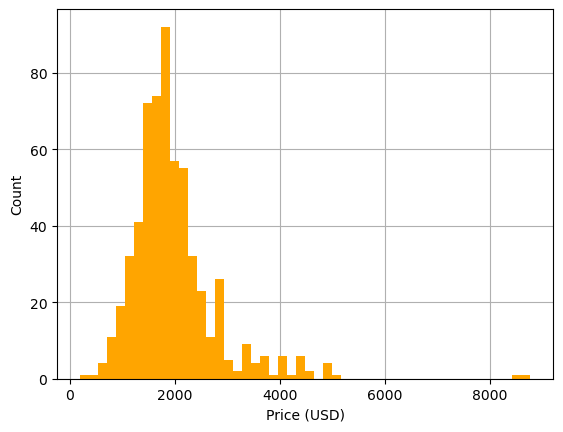

In [47]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.hist(results['price'],bins=50,color='orange')

plt.ylabel('Count')
plt.xlabel('Price (USD)')
plt.grid()
ax.set_axisbelow(True)

plt.show()

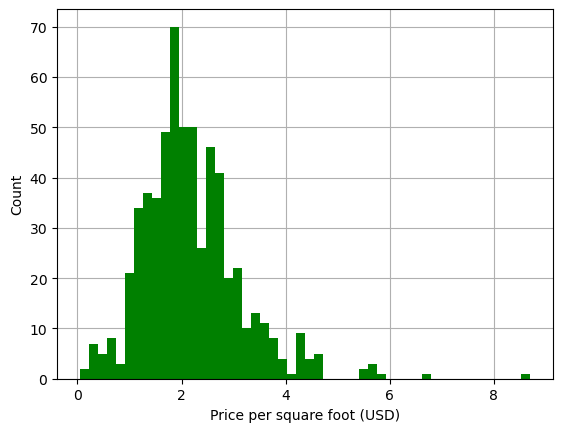

In [48]:
fig, ax = plt.subplots()

results['price_sqft'] = results['price'] / results ['size']

ax.hist(results['price_sqft'],bins=50,color='green')

plt.ylabel('Count')
plt.xlabel('Price per square foot (USD)')
plt.grid()
ax.set_axisbelow(True)

plt.show()

#### Side note: rental prices per sq. ft. from Craigslist

The histogram of price per sq ft should be centered around ~1.5. Here is a plot of how Philadelphia's rents compare to the other most populous cities:

<img src="imgs/rental_prices_psf.png" width=600/>

[Source](https://arxiv.org/pdf/1605.05397.pdf)

### 2.8 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [49]:
import altair as alt

In [51]:
alt.Chart(results).mark_circle(size=10).encode(
    x='price:Q',
    y='size:Q',
    color=alt.Color('bedrooms:O', scale=alt.Scale(scheme = 'viridis')),
    tooltip=['title','price', 'size', 'bedrooms']
).interactive()

alt.Chart(...)